# Contrôle optimal d'une pandémie par apprentissage par renforcement 

**Modèle SEIRD** 
Nous utilisons les algorithmes Q-Learning, SARSA et essayons DP approché pour résoudre le problème de contrôle sur les états $S$,$E$,$I$.

L'environnement simule la dynamique SEIRD complète (voir `model.py`), mais l'agent observe uniquement $(S, E, I)$ discrétisé en bins non-uniformes. Comme démontré dans le rapport, $R$ et $D$ n'influencent pas la dynamique et peuvent être obtenus par des équations redondantes.

**Contrôles :**
- $u_{conf} \in \{0, 0.25, 0.5, 0.75, 1\}$ — niveau de confinement
- $u_{vacc} \in \{0, 0.25, 0.5, 0.75, 1\}$ — intensité de vaccination (×max_vacc_rate)

Nous proposons 25 actions à tester.

In [36]:
%reload_ext autoreload
%autoreload 2

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from model import SEIREnv, ProblemConfig, SocioEconomicConfig
from utils import default_bin_dicts, state_to_id, bin_center, problem_sizes, record_episode
from algorithms import QLearningAgent, SarsaAgent, RLConfig
from heuristics import policy_no_control, policy_vacc_max, policy_seuil_conf, policy_double_seuil
from plotting import (
    plot_learning_curves, plot_seird_evolution, plot_commands,
    plot_epidemic_comparison, plot_cost_decomposition, plot_sensitivity,
)
from dynamic_programming import run_approximate_dp

In [38]:
plt.rcParams.update(
    {
        "figure.figsize": (14, 5),
        "axes.grid": True,
        "font.size": 11,
    }
)

config = ProblemConfig()
print(
    f"Paramètres épidémiologiques : \n"
    f"β={config.beta},\n"
    f"σ={config.sigma},\n"
    f"γ={config.gamma},\n"
    f"μ={config.mu}"
)
print(f"R₀ = β/γ = {config.beta / config.gamma:.2f}")
print(f"Horizon = {config.max_steps} jours, dt = {config.dt}")
print(f"\nCoûts (normalisés C_eco=1) :")
c = config.socio_eco_config
print(
    f"C_eco={c.confinement_eco_cost},\n"
    f"C_vacc={c.vaccination_eco_cost},\n"
    f"C_vie={c.life_cost}, \n"
    f"C_hosp={c.infection_cost}"
)

Paramètres épidémiologiques : 
β=0.27,
σ=0.14,
γ=0.1,
μ=0.01
R₀ = β/γ = 2.70
Horizon = 365 jours, dt = 1.0

Coûts (normalisés C_eco=1) :
C_eco=1.0,
C_vacc=0.02,
C_vie=1000.0, 
C_hosp=20


## 1. Discrétisation de l'espace d'états et d'actions

**État réduit :** On ne garde que $(S, E, I)$ car les équations de transition de $S$, $E$, $I$ ne dépendent ni de $R$ ni de $D$. C'est Markovien pour la partie utile à la décision.

**Bins non-uniformes :** Plus fins près de 0 pour $E$ et $I$ (là où se jouent les transitions critiques).

- $S$ : 11 bins — $[0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.97, 0.985, 1.00]$
- $E, I$ : 11 bins — $[0, 10^{-5}, 3{\times}10^{-5}, 10^{-4}, 3{\times}10^{-4}, 10^{-3}, 3{\times}10^{-3}, 10^{-2}, 3{\times}10^{-2}, 0.1, 0.3, 0.5 1.00]$

On suppose qu'il est peu probable, rapporté à la population, que $E$ ou $I$ dépasse 30%.

→ $11^3 = 1331$ états possibles (en pratique moins car $S+E+I \leq 1$).

**Actions :** Grille $5 \times 5$ → 25 actions discrètes.

In [39]:
S_bins = np.array([0,0.2, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.97, 0.985, 1.0])
E_bins = np.array([0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 0.5, 1.0])

bin_dicts = {
    "S_bins": S_bins,
    "E_bins": E_bins,
    "I_bins": E_bins.copy(),
}
nS = len(bin_dicts["S_bins"]) - 1
nE = len(bin_dicts["E_bins"]) - 1
nI = len(bin_dicts["I_bins"]) - 1
n_states = nS * nE * nI
print(f"Nombre d'états discrétisés : {nS}×{nE}×{nI} = {n_states}")


Nombre d'états discrétisés : 12×12×12 = 1728


In [40]:
### présentation de la grille

In [41]:
## Actions
vals = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
actions = np.array([(c, v) for c in vals for v in vals])
n_actions = len(actions)
print(f"Nombre d'actions discrétisées : {n_actions} (confinement, vaccination) ∈ {vals}²")
bin_dicts["actions"] = actions

Nombre d'actions discrétisées : 25 (confinement, vaccination) ∈ [0.   0.25 0.5  0.75 1.  ]²


# Entrainements

## 2.1 Configs


In [42]:
n_episodes = 5000
epsilon_decay = (1.0 - 0.05) / (n_episodes / 2)

rl_configs = RLConfig(
    learning_rate=0.1,
    initial_epsilon=1.0,
    epsilon_decay=epsilon_decay,
    final_epsilon=0.05,
    discount_factor=0.99,
)


## 2.2 Q-learning
$$Q(s,a) \leftarrow Q(s,a) + \alpha \Big( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \Big)$$

Boucle d'entraînement suivant le pattern [Gymnasium — Training an Agent](https://gymnasium.farama.org/introduction/train_agent/) sur un problème de black jack

In [ ]:
env = SEIREnv(config)
agent_ql = QLearningAgent(
    n_states,
    n_actions,
    bin_dicts,
    configs=rl_configs
)

costs_ql = []

for episode in tqdm(range(n_episodes), desc="Q-Learning"):
    obs, info = env.reset()
    done = False
    episode_reward = 0.0

    while not done:
        action_id, action = agent_ql.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent_ql.update(obs, action_id, reward, terminated, next_obs)

        episode_reward += reward
        done = terminated or truncated
        obs = next_obs

    agent_ql.decay_epsilon()
    costs_ql.append(episode_reward)

Q-Learning:   0%|          | 0/5000 [00:00<?, ?it/s]

Q-Learning:   2%|▏         | 114/5000 [00:04<03:07, 26.02it/s]

## 2.3 SARSA (on-policy)

$$Q(s,a) \leftarrow Q(s,a) + \alpha \Big( r + \gamma \, Q(s',a') - Q(s,a) \Big)$$

In [ ]:
agent_sarsa = SarsaAgent(
    n_states,
    n_actions,
    bin_dicts,
    configs=rl_configs
)

costs_sarsa = []

for episode in tqdm(range(n_episodes), desc="SARSA"):
    obs, info = env.reset()
    action_id, action = agent_sarsa.get_action(obs)
    done = False
    episode_reward = 0.0

    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_action_id, next_action = agent_sarsa.get_action(next_obs)

        agent_sarsa.update(obs, action_id, reward, terminated, next_obs, next_action_id)

        episode_reward += reward
        done = terminated or truncated
        obs = next_obs
        action_id, action = next_action_id, next_action

    agent_sarsa.decay_epsilon()
    costs_sarsa.append(episode_reward)

SARSA: 100%|██████████| 5000/5000 [03:49<00:00, 21.75it/s]


## 2.4 apprentissage Q-Learning & SARSA

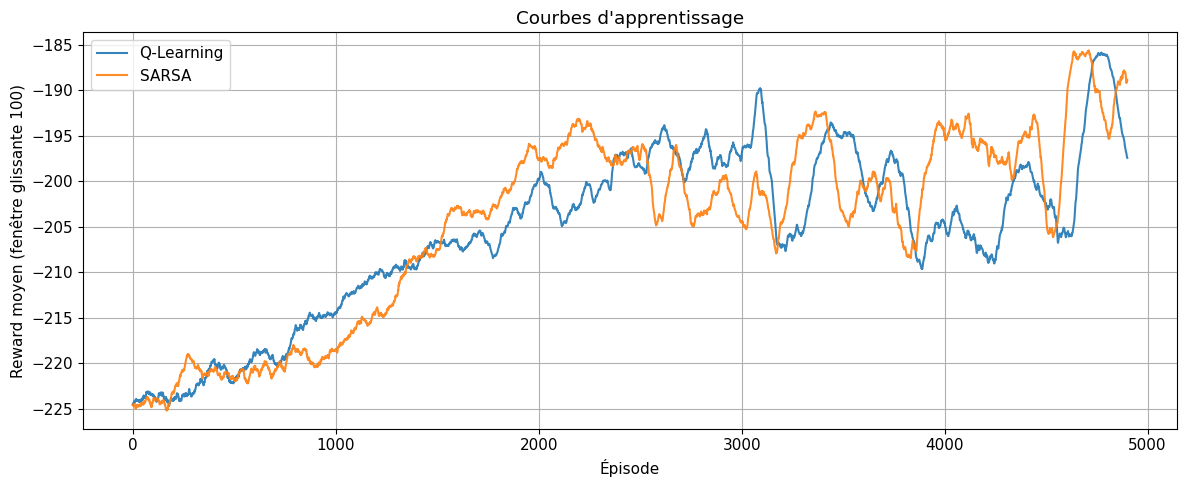

In [ ]:
plot_learning_curves({"Q-Learning": costs_ql, "SARSA": costs_sarsa})

# 2.5 Programmation dynamique approchée

$$V_t(s) = \max_a \Big( \hat{\mathbb{E}}[r(s,a,S')] + \gamma \, \hat{\mathbb{E}}[V_{t+1}(S')] \Big)$$

L'espérance est estimée par $K$ simulations Monte-Carlo depuis le centre de chaque bin. C'est de la **DP approchée** car l'espace continu est discrétisé et les transitions sont estimées empiriquement.

In [ ]:
V_dp, pi_dp = run_approximate_dp(config, bin_dicts, K=3, gamma=0.99)

# 3. Evaluations

On compare les agents RL avec les heuristiques et la DP approchée

## 3.1 Comparaison des coûts finaux

In [ ]:
env_eval = SEIREnv(config)
results = {}

# Heuristiques
for name, pol_fn in [
    ("Aucun contrôle", policy_no_control),
    ("Vaccination max", policy_vacc_max),
    ("Seuil confinement", policy_seuil_conf),
    ("Double seuil", policy_double_seuil),
]:
    r, h = record_episode(env_eval, pol_fn)
    results[name] = h
    print(f"{name:25s} → reward total = {r:10.1f}")

# Q-Learning greedy
r, h = record_episode(env_eval, agent_ql.greedy_policy)
results["Q-Learning"] = h
print(f"{'Q-Learning':25s} → reward total = {r:10.1f}")

# SARSA greedy
r, h = record_episode(env_eval, agent_sarsa.greedy_policy)
results["SARSA"] = h
print(f"{'SARSA':25s} → reward total = {r:10.1f}")

# # DP approchée (politique time-dependent)
env_dp_eval = SEIREnv(config)


def policy_dp(obs):
    """Politique DP approchée (dépend du step courant)."""
    s = state_to_id(obs, bin_dicts)
    t = min(env_dp_eval.current_step, config.max_steps - 1)
    return actions[pi_dp[t, s]]


r, h = record_episode(env_dp_eval, policy_dp)
results["DP approchée"] = h
print(f"{'DP approchée':25s} → reward total = {r:10.1f}")


Aucun contrôle            → reward total =     -183.5
Vaccination max           → reward total =     -176.3
Seuil confinement         → reward total =     -233.6
Double seuil              → reward total =     -175.1
Q-Learning                → reward total =     -190.3
SARSA                     → reward total =     -178.7


## 3.2 Evolution de la population

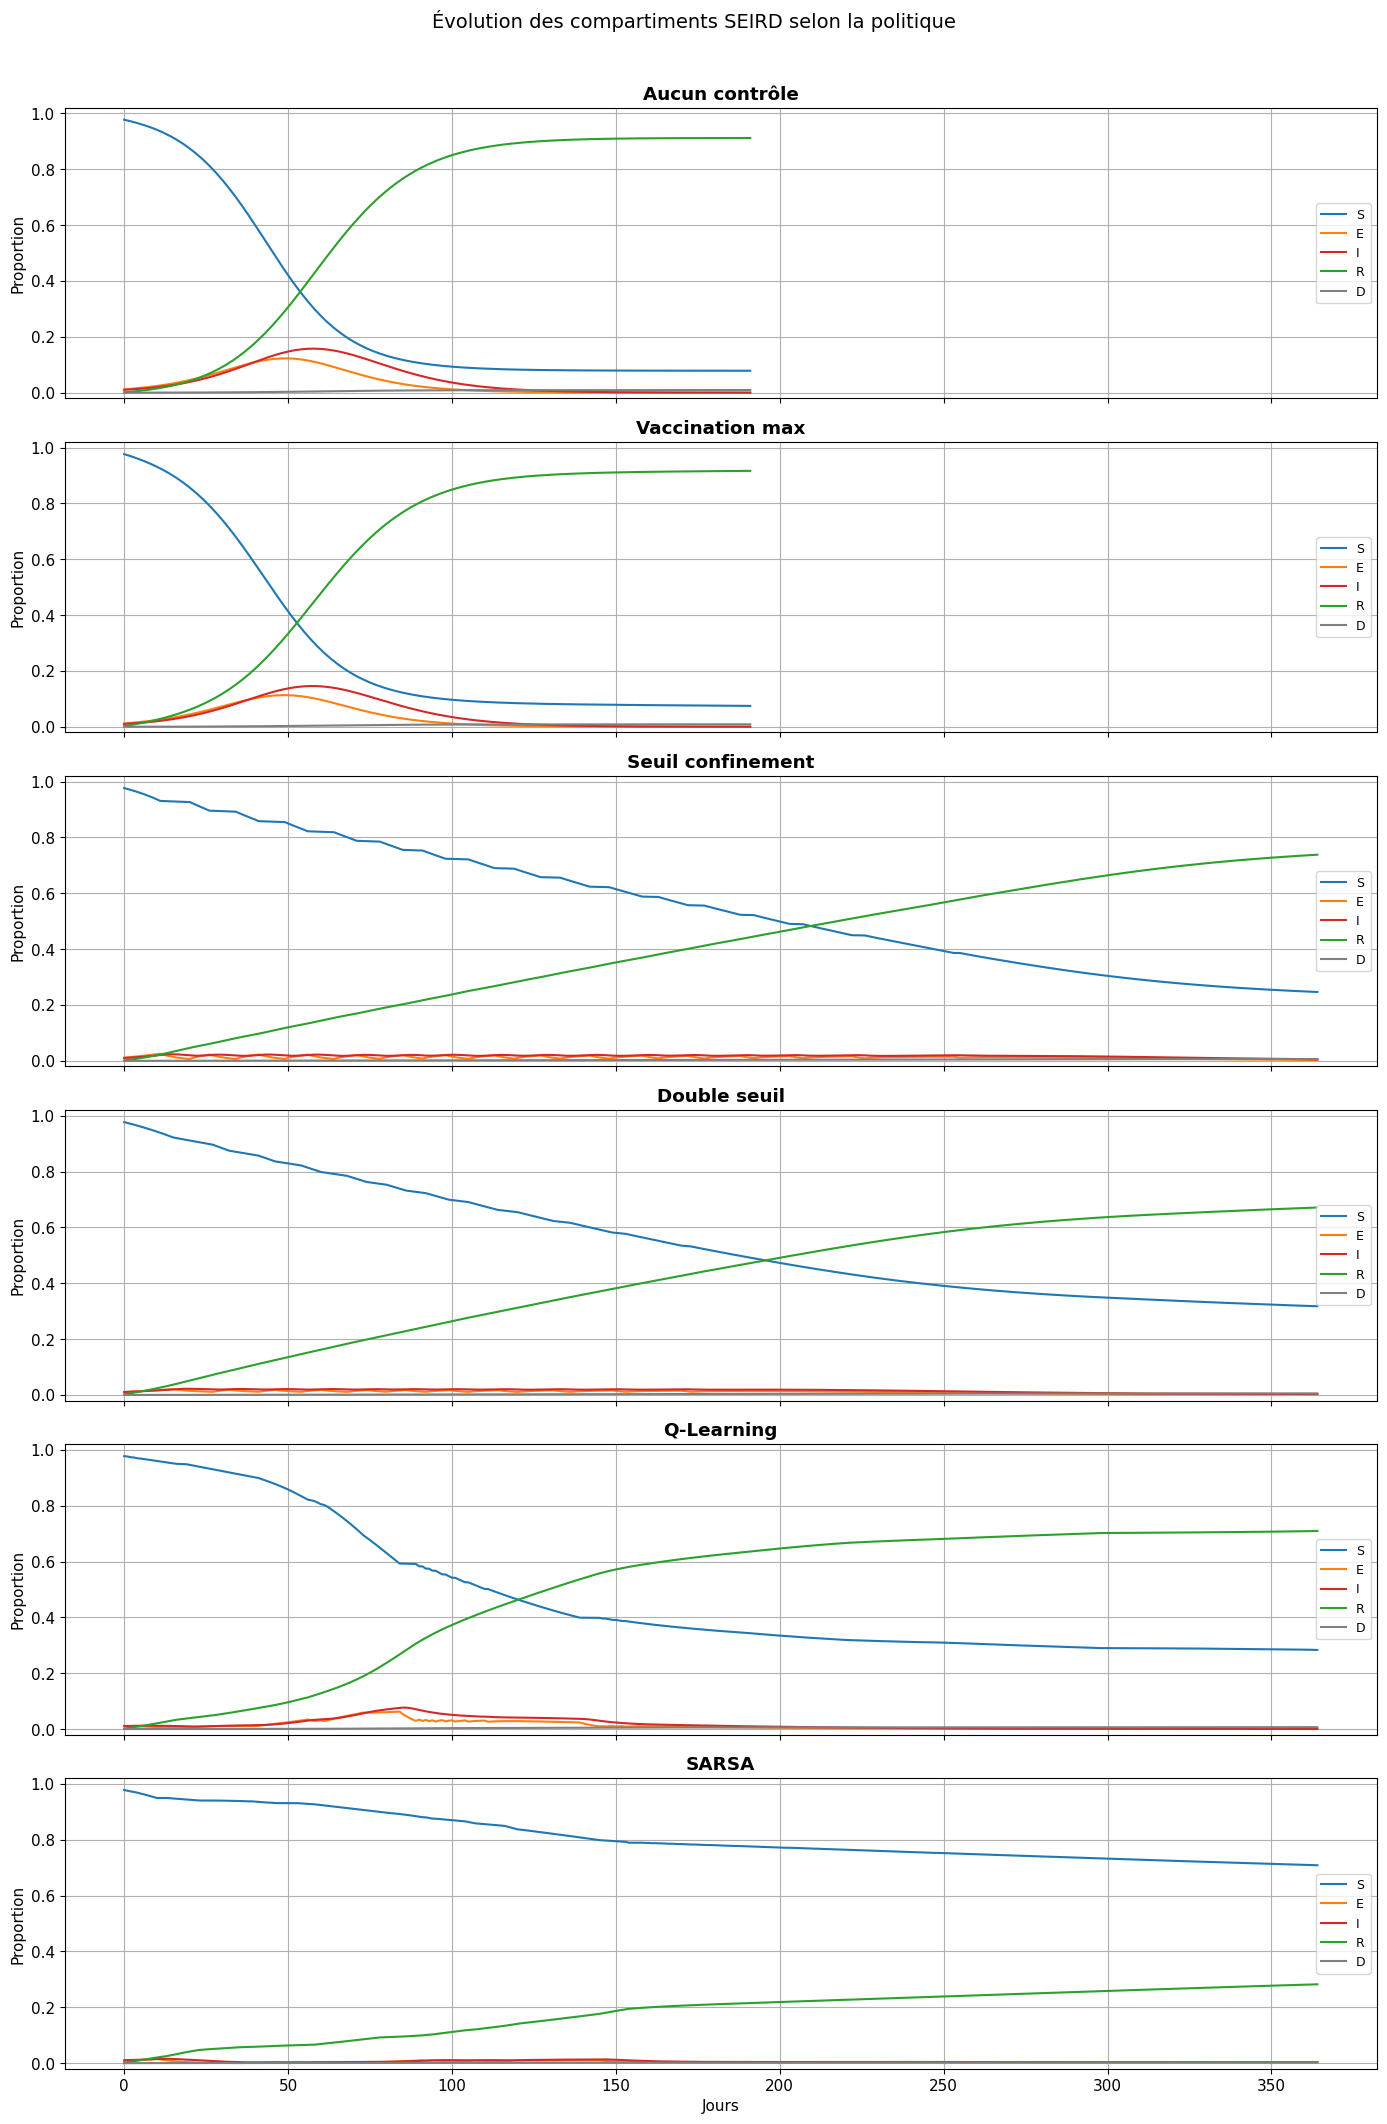

In [ ]:
policy_names = list(results.keys())
plot_seird_evolution(results, policy_names)

## 3.3 Evolution des commandes en fonction de l'algorithme
On Compare ci-dessous les réactions pour chaque niveau d'action

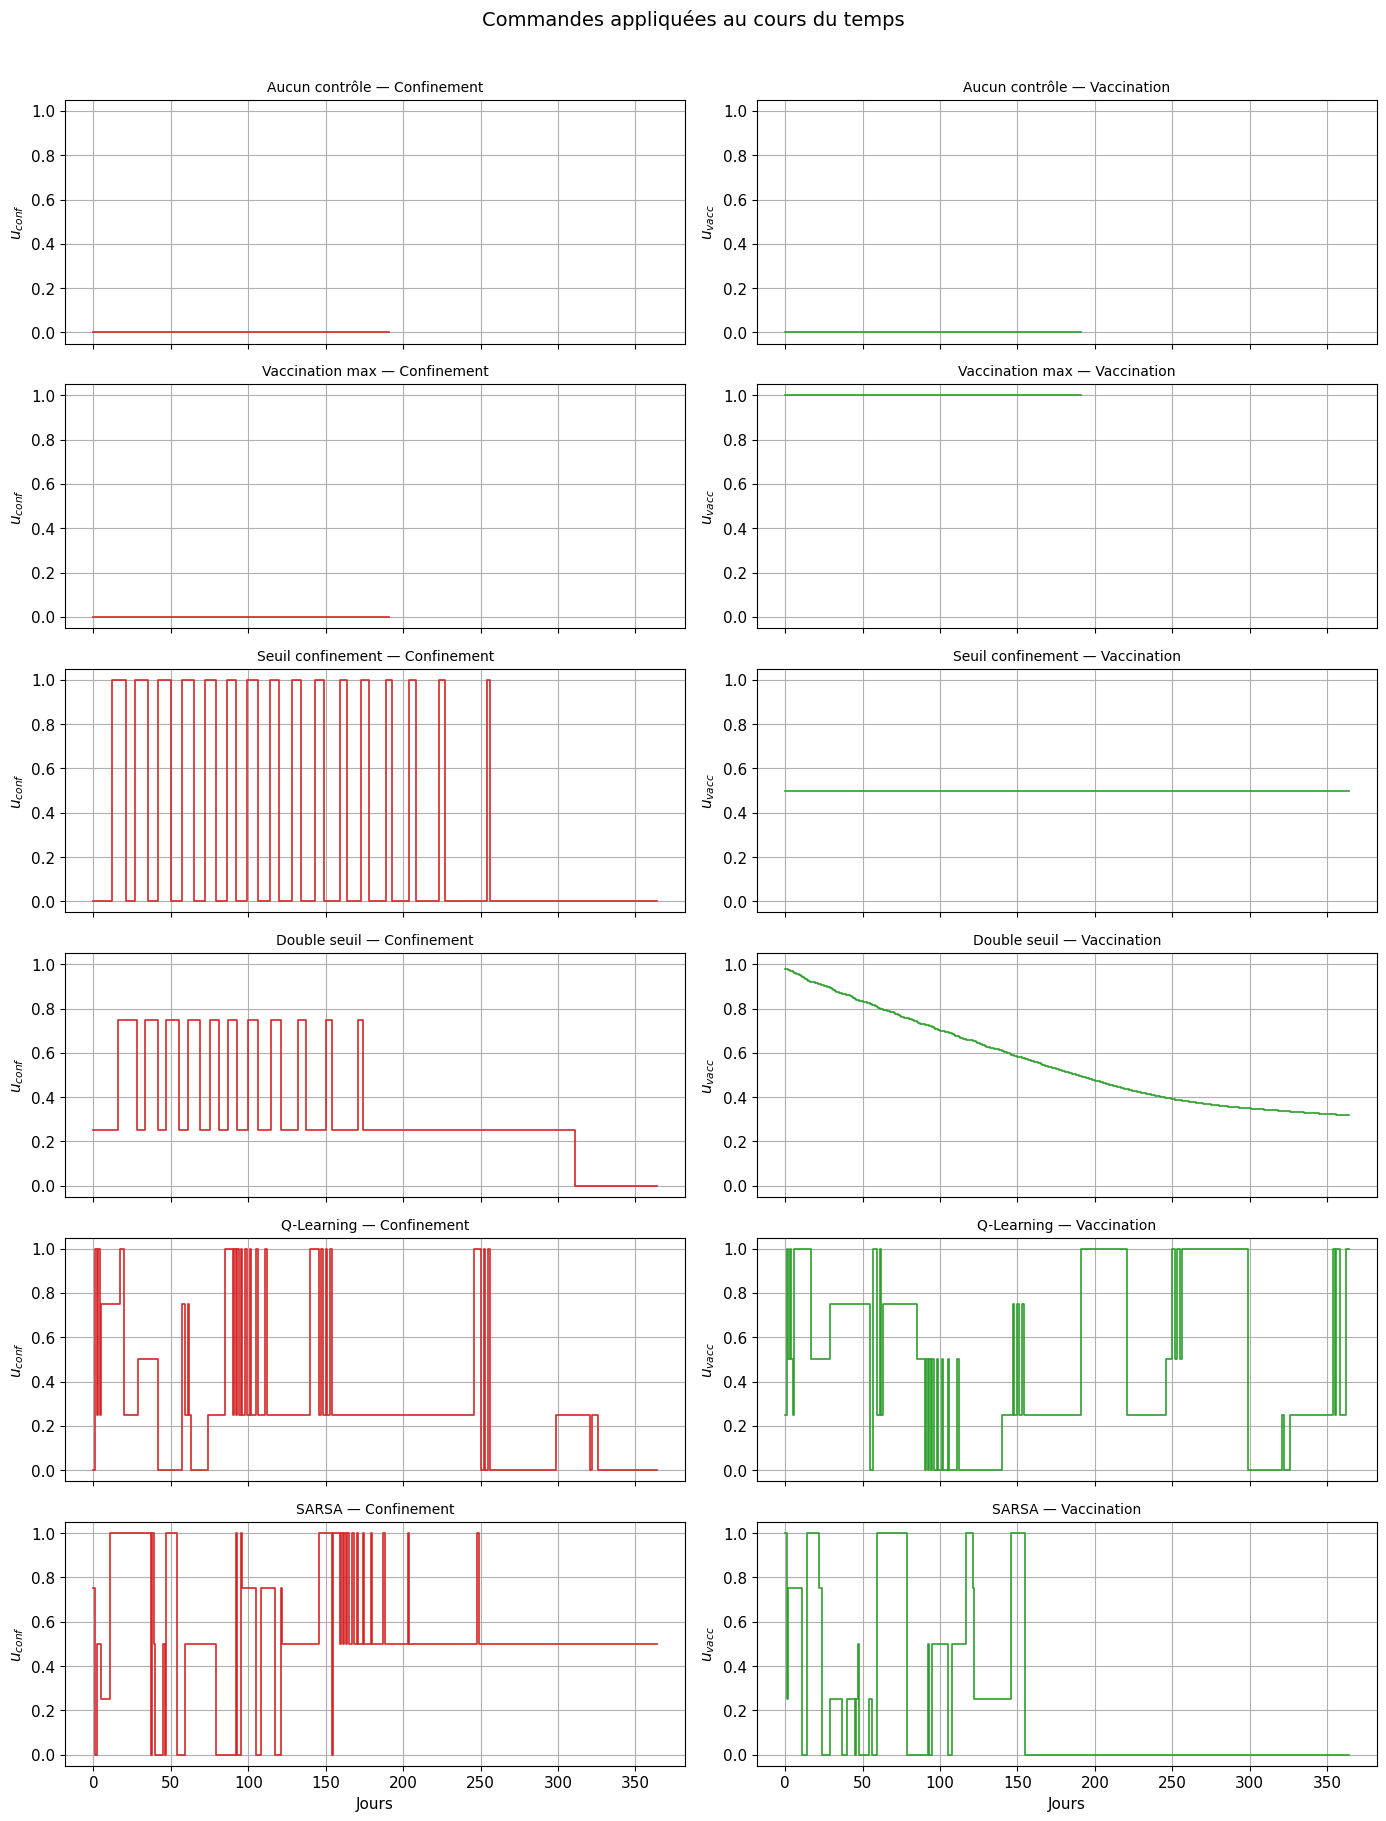

In [ ]:
plot_commands(results, policy_names)

## 3.4 Population infectée et décès

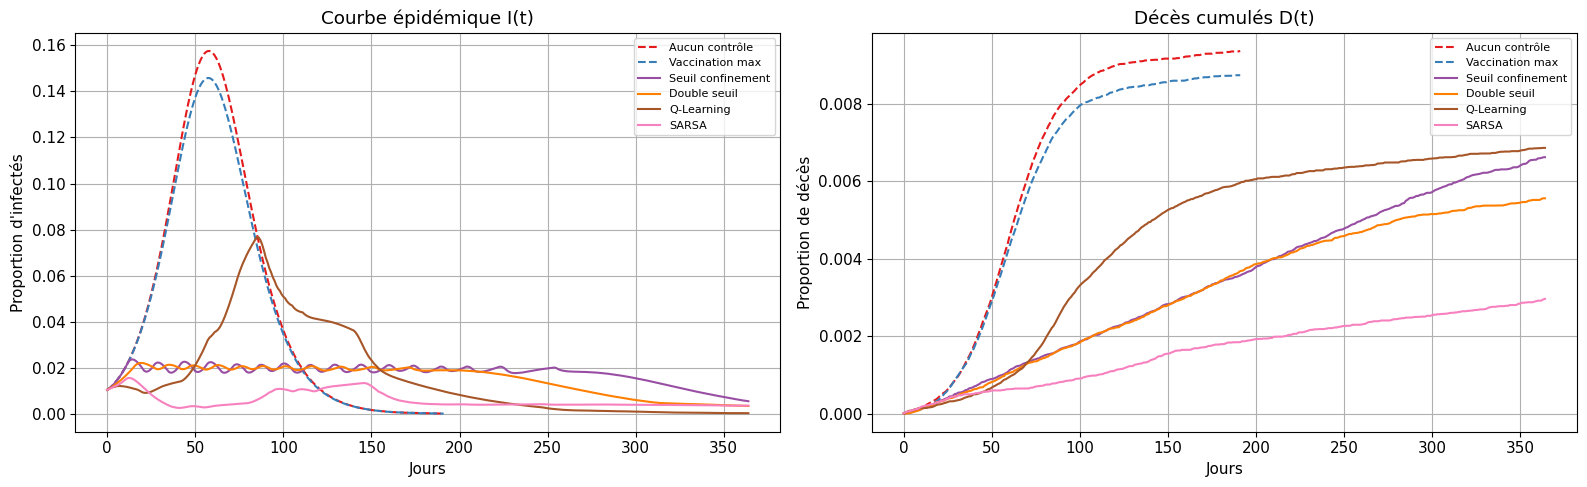

In [ ]:
plot_epidemic_comparison(results, policy_names)

## 3.5 Coûts pour chaque politique
Les graphiques ci-dessous présentent l'apport de chaque composante du coût en fonction de la politique choisie.

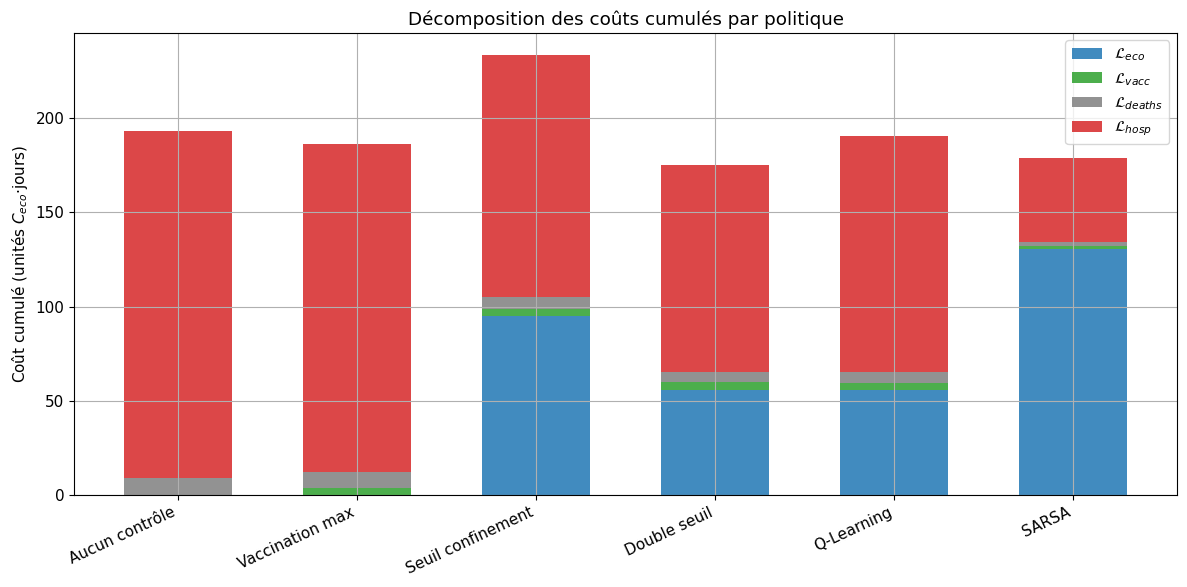


Politique                 |      L_eco |     L_vacc |   L_deaths |     L_hosp |      TOTAL
-------------------------------------------------------------------------------------
Aucun contrôle            |        0.0 |        0.0 |        9.2 |      184.3 |      193.5
Vaccination max           |        0.0 |        3.8 |        8.7 |      173.7 |      186.3
Seuil confinement         |       95.0 |        3.6 |        6.4 |      128.6 |      233.6
Double seuil              |       55.9 |        4.1 |        5.5 |      109.6 |      175.1
Q-Learning                |       55.6 |        3.6 |        6.2 |      124.9 |      190.3
SARSA                     |      130.9 |        1.4 |        2.2 |       44.1 |      178.7


In [ ]:
plot_cost_decomposition(results, policy_names)